# Networks Final Project: Initial Analysis

In [2]:
#imports
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#constants
%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 8

In this notebook, I will initially begin to analyze the Offshore Leaks Database network.

In [3]:
#load in the dataset
fullNetwork = nx.read_gpickle("../data/processed/fullNetwork.pkl")

## Summary Statistics

We will begin by getting some general summary statistics on the network in terms of nodes, edges, and general network information.

### Node Information

In [4]:
numNodes = len(fullNetwork.nodes())

We see that there are {{numNodes}} nodes in this network.

In [29]:
#make function for getting information about particular nodes
def getNodeInfo(nodeVec,keyName):
    #helper for returning a list of node information over the whole list of
    #nodes
    nodeInfoDict = {"nodeID":[],keyName:[]}
    for nodeTup in nodeVec:
        #0th entry is ID
        nodeInfoDict["nodeID"].append(nodeTup[0])
        #then get key info
        givenNodeDict = nodeTup[1]
        nodeInfoDict[keyName].append(givenNodeDict[keyName])
    return nodeInfoDict
#then make data frame of information
nodeVec = fullNetwork.nodes(data = True)
nodeEntFrame = pd.DataFrame(getNodeInfo(nodeVec,"entType"))
nodeCountryFrame = pd.DataFrame(getNodeInfo(nodeVec,"countrycodes"))

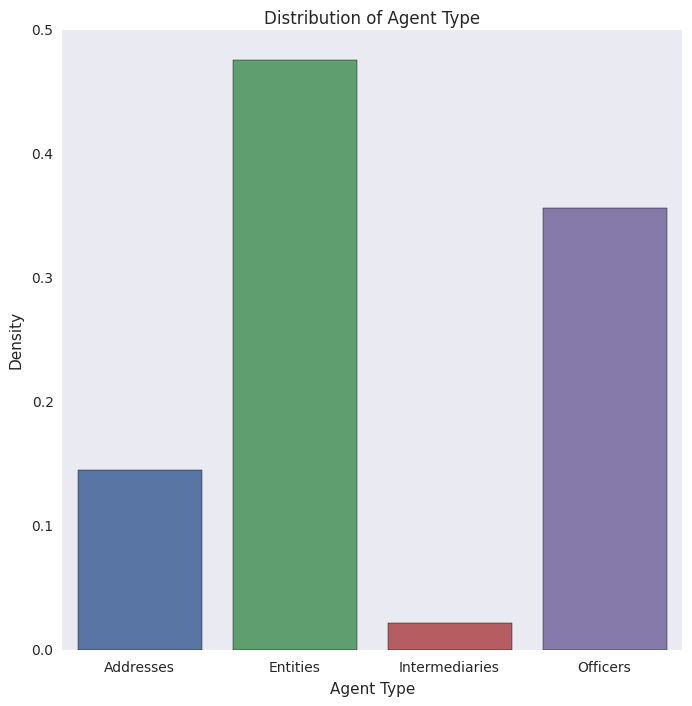

In [30]:
#then get entity distribution
entCountFrame = nodeEntFrame.groupby("entType",
                                     as_index = False)["nodeID"].count()
entCountFrame = entCountFrame.rename(columns = {"nodeID":"count"})
entCountFrame["density"] = entCountFrame["count"] / sum(entCountFrame["count"])
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "entType",y = "density",data = entCountFrame)
plt.xlabel("Agent Type")
plt.ylabel("Density")
plt.title("Distribution of Agent Type")

_Figure 1: Distribution of Agent Type._

We see that entities and officers make up a significant portion of the dataset. Interestingly, there are more entities than officers, which suggests that these dealings are very slim in terms of head count and tend to feature many different entities at once. Interestingly, Intermediaries take up a very small portion of the dataset. That being said, given my [original analysis for my proposal](../proposal/finalProjectProposal.pdf), it is likely that these intermediaries will play a very important part in the network.

In [31]:
countryCountFrame = nodeCountryFrame.groupby("countrycodes",
                                             as_index = False)["nodeID"].count()
countryCountFrame = countryCountFrame.rename(columns =
                                             {"countrycodes":"countryCode",
                                              "nodeID":"count"})
countryCountFrame = countryCountFrame.sort_values("count",ascending = False)
numCountryCodes = countryCountFrame.shape[0]

We see that there are {{numCountryCodes}} country codes represented in this dataset. Note that this is more than the number of countries recognized by the UN (196), Which suggests that some of these country codes are hybrid codes or are for particular territories. Given the nature of certain territories to offer favorable tax regimes, it would not surprise me if this is the case.

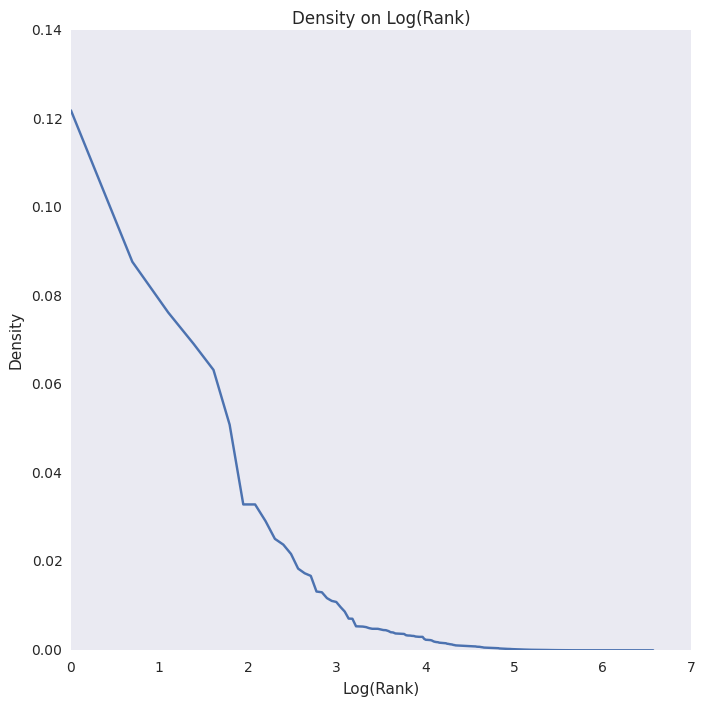

In [32]:
countryCountFrame["density"] = (countryCountFrame["count"] /
                                sum(countryCountFrame["count"]))
countryCountFrame["rank"] = range(countryCountFrame.shape[0])
countryCountFrame["logRank"] = np.log(countryCountFrame["rank"] + 1)
#then plot rank-density
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.plot(countryCountFrame["logRank"],countryCountFrame["density"])
plt.xlabel("Log(Rank)")
plt.ylabel("Density")
plt.title("Density on Log(Rank)")

_Figure 2: $\log(Rank)$ on density for country code._

We see that the density disapates around $e^4 \approx 56$ country codes. Given that this is $\approx \frac{56}{716} \cdot 100\% \approx 7.82\%$ of all country codes, this is not the sparsest distribution, although it is relatively sparse. This may suggest that we will need to do some data cleaning for low-count country codes if we are interested in studying the countries of our agents.

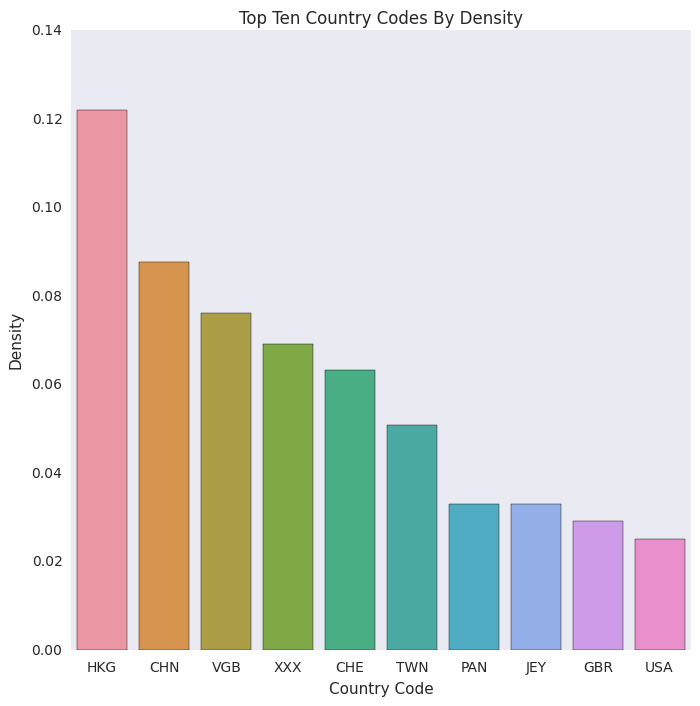

In [33]:
#get top 10 country codes
topLev = 10
topTenCountryCodes = countryCountFrame.iloc[0:topLev,:]
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "countryCode",y = "density",data = topTenCountryCodes)
plt.xlabel("Country Code")
plt.ylabel("Density")
plt.title("Top Ten Country Codes By Density")

_Figure 3: Top ten country codes by density._

Interestingly, we see that around  $7\%$ of our nodes feature a non-existent country code, labeled "XXX." This may suggest some form of missing value, although we should explore the ICIJ documentation on the Offshore Leaks Database to confirm. We see that Hong Kong and China ("HKG" and "CHN" respectively) seem to have the largest number of agents from within our dataset, which may suggest a potentially strong focus on Hong Kong as an east Asian tax haven. There seems to be more evidence for this when Taiwan ("TWN") seems to show up quite often as well. The British Virgin Islands and Jersey ("VGB" and "JEY" respectively) also are quite common, which is expected given their favorable tax regimes in relation to their proprietor country (United Kingdom). Panama ("PAN") also has a meaningful portion of the distribution, which is expected given the fact that one of the major leaking organizations in this database, Mossack Fonseca, is based out of Panama, and it is likely that they are associated with many entities within Panama. Given the notoriety of the tax-friendly Swiss banking system, it is also not peculiar that Switzerland ("CHE") has many agents within this dataset.

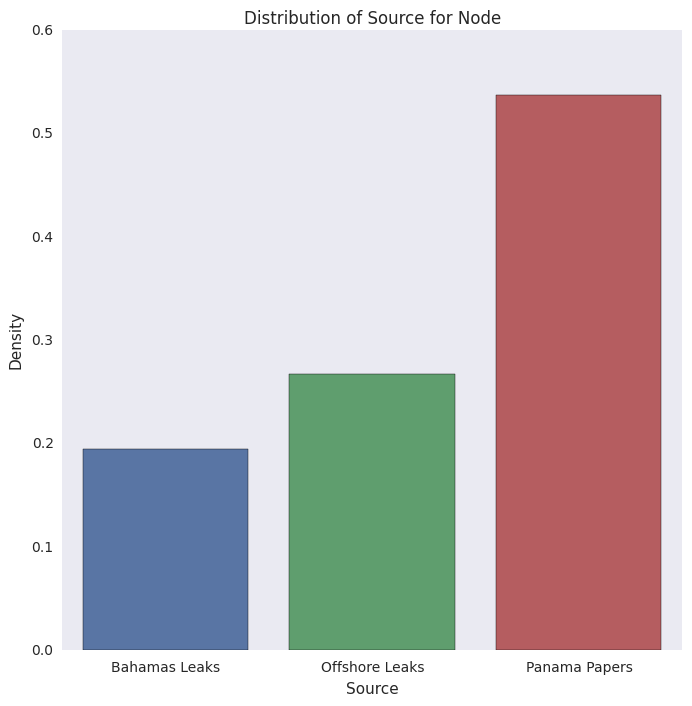

In [13]:
#get source information
nodeSourceFrame = pd.DataFrame(getNodeInfo(nodeVec,"sourceID"))
sourceByCountFrame = nodeSourceFrame.groupby("sourceID",as_index = False)[
                                                "nodeID"].count()
#rename some information
sourceByCountFrame = sourceByCountFrame.rename(columns = {"nodeID":"count"})
#get density
sourceByCountFrame["density"] = (sourceByCountFrame["count"] /
                                    sum(sourceByCountFrame["count"]))
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "sourceID",y = "density",data = sourceByCountFrame)
plt.xlabel("Source")
plt.ylabel("Density")
plt.title("Distribution of Source for Node")

_Figure 4: Distribution of Node Sources._

We see that the Panama Papers is the source of the majority of the nodes, although the Bahamas Leaks and the Offshore Leaks still have sizable representations in the node-side of the network. It would be interesting to compare this to the distribution of edge sources in the network.

### Edge Information

In [14]:
numEdges = len(fullNetwork.edges())

There are {{numEdges}} edges in this network.

In [16]:
def getEdgeInfo(edgeVec,keyName):
    #helper for returning a list of edge information over the whole list of
    #edges
    edgeInfoDict = {"edgeID":[],keyName:[]}
    for edgeTup in edgeVec:
        #0th entry is ID
        edgeInfoDict["edgeID"].append(edgeTup[0])
        #then get key info
        givenEdgeDict = edgeTup[2]
        edgeInfoDict[keyName].append(givenEdgeDict[keyName])
    return edgeInfoDict
#then get edge sources
edgeVec = fullNetwork.edges(data = True)
edgeSourceFrame = pd.DataFrame(getEdgeInfo(edgeVec,"sourceID"))

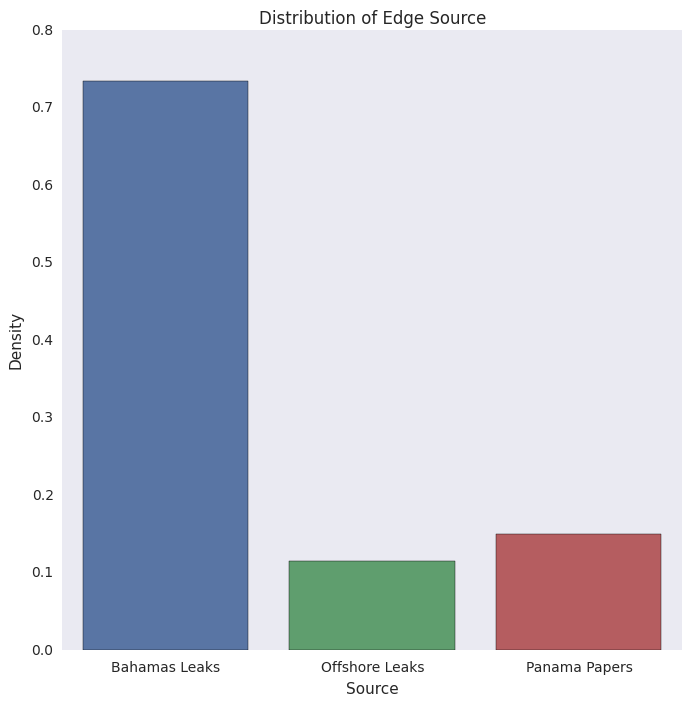

In [19]:
#then group by source
edgeSourceByCount = edgeSourceFrame.groupby("sourceID",as_index = False)[
                                "edgeID"].count()
edgeSourceByCount = edgeSourceByCount.rename(columns = {"edgeID":"count"})
edgeSourceByCount["density"] = (edgeSourceByCount["count"] /
                                    sum(edgeSourceByCount["count"]))
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "sourceID",y = "density",data = edgeSourceByCount)
plt.xlabel("Source")
plt.ylabel("Density")
plt.title("Distribution of Edge Source")

_Figure 5: Distribution of Edge Sources._

Interestingly, while the Bahamas Leaks have fewer nodes in the network than the Offshore Leaks and Panama Papers (see Figure 4), they represent a large portion of the edges in this network. This may suggest that the Bahamas Leaks subnetwork is significantly more dense than the Offshore Leaks and Panama Papers subnetworks. This may have broader implications on studying the edge-intensive behavior of certain nodes on the network, as it may be biased to emphasize the countries more represented in the Bahamas Leaks than the countries more represented in the other leaks.

In [22]:
#get edgeType
edgeTypeFrame = pd.DataFrame(getEdgeInfo(edgeVec,"reltype"))
edgeTypeCountFrame = edgeTypeFrame.groupby("reltype",as_index = False)[
                                            "edgeID"].count()
edgeTypeCountFrame = edgeTypeCountFrame.rename(columns = {"edgeID":"count"})
#get number of edge types
numEdgeTypes = edgeTypeCountFrame.shape[0]

We see that there are {{numEdgeTypes}} different types of edges in this network. This suggests that this might be a variable that will be difficult to analyze. That being said, let us see how sparse this edge type distribution is.

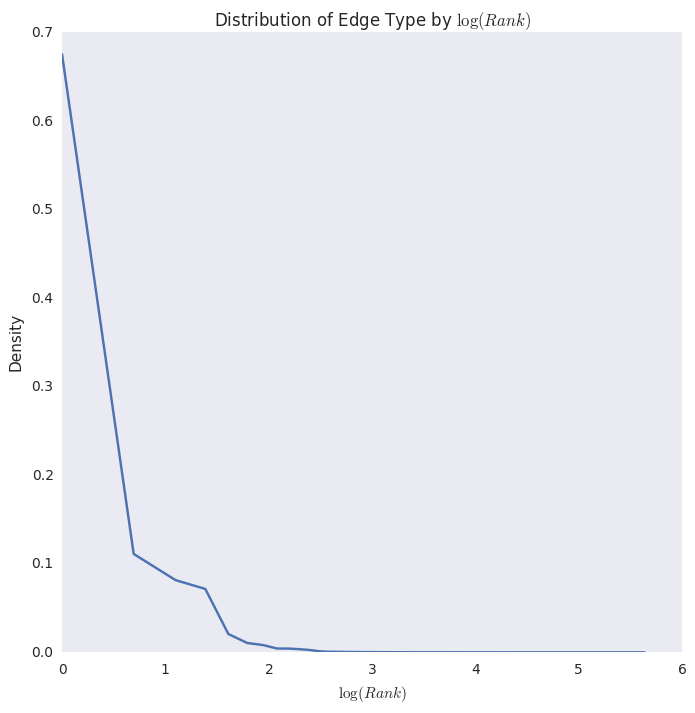

In [26]:
def getDensityInFrame(givenDataFrame,countVarname):
    #helper for getting density within a given data frame
    givenDataFrame["density"] = (givenDataFrame[countVarname] /
                                    sum(givenDataFrame[countVarname]))
    return givenDataFrame
edgeTypeCountFrame = getDensityInFrame(edgeTypeCountFrame,"count")
edgeTypeCountFrame = edgeTypeCountFrame.sort_values("density",ascending = False)
edgeTypeCountFrame["rank"] = range(edgeTypeCountFrame.shape[0])
edgeTypeCountFrame["logRank"] = np.log(edgeTypeCountFrame["rank"] + 1)
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
plt.plot(edgeTypeCountFrame["logRank"],edgeTypeCountFrame["density"])
plt.xlabel("$\log(Rank)$")
plt.ylabel("Density")
plt.title("Distribution of Edge Type by $\log(Rank)$")

_Figure 6: Distribution of Edge Types by $\log(Rank).$_

As we can see, this is an extremely sparse distribution, as our density seems to bottom out after the $e^2 \approx 8$ most frequent levels of edge type. Let us take a look at these edge relationships to see if they are in fact meaningful to our analysis.

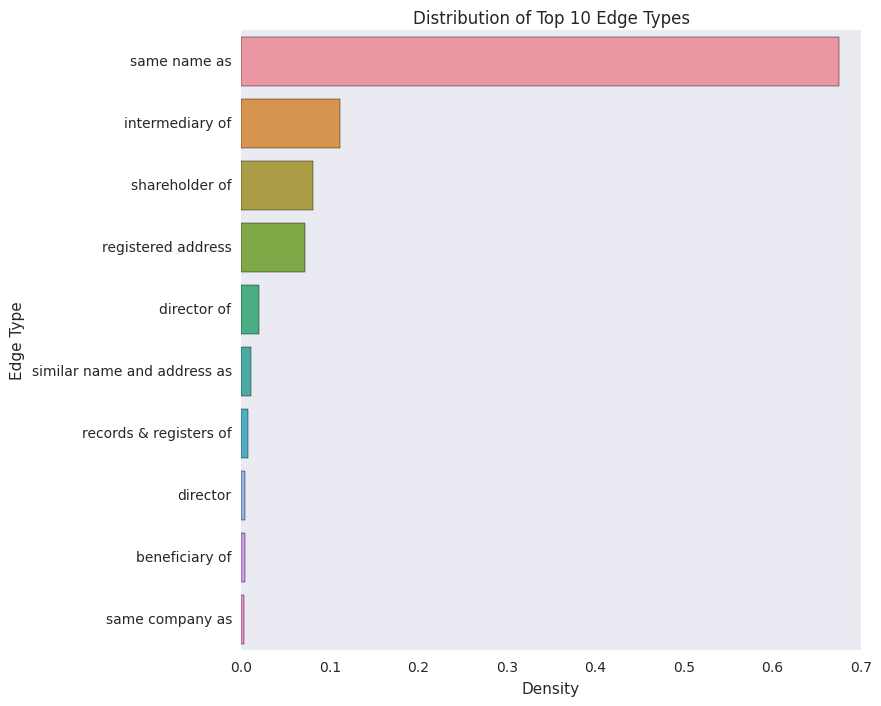

In [37]:
topTenEdgeTypes = edgeTypeCountFrame.iloc[0:topLev,:]
#plot it
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(y = "reltype",x = "density",data = topTenEdgeTypes,orient = "h")
plt.xlabel("Density")
plt.ylabel("Edge Type")
plt.title("Distribution of Top 10 Edge Types")

TODO:

* Fix link under Figure 1.
* Find out what "XXX" and ";" mean for a particular node's country code